<font color=gray>ADS Sample Notebook.

Copyright (c) 2020 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Introduction to the Model Catalog</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Team </font></p>

***

## Overview:

The model catalog provides a method to track and immutably store models. This allows organizations to maintain the provenance of models during all phases of a model's lifecycle. This notebook demonstrates CRUD (create, read, update, delete) operations on models. It contains details on how to prepare model artifacts, save models (including their metadata) into the model catalog and also the showcases methods used to list, load, and delete models from the catalog. 

A model artifact includes the model, metadata about the model, and scripts to load the model and make predictions on it. These model artifacts can be shared among data scientists, tracked for provenance, reproduced, and deployed.

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

## Prerequisites:
 - Experience with the topic: Novice
 - Professional experience: None
 
---

## Objectives:
This notebook covers the following topics:
 - <a href='#intro'>Introduction to the Model Catalog</a>
 - <a href='#prepare'>Preparing a Model Artifact</a>
     - <a href='#prepare_adsmodel'>Preparing an `ADSModel`</a>
         - <a href='#prepare_adsmodel_train'>Training an `ADSModel`</a>
         - <a href='#prepare_adsmodel_ma'>Preparing the Model Artifact</a>
         - <a href='#prepare_adsmodel_modify'>Modifying the Model Artifact Files</a>
     - <a href='#prepare_generic'>Preparing a Generic Model</a>
         - <a href='#prepare_generic_train'>Training a Generic Model</a>
         - <a href='#prepare_generic_ma'>Serializing the Model and Preparing the Model Artifact</a>
         - <a href='#prepare_generic_modify'>Modifying the Model Artifact Files</a>
 - <a href='#save'>Saving the Model Artifact to the Model Catalog</a>
 - <a href='#list'>Listing Models in the Model Catalog</a>
 - <a href='#download'>Downloading a Model Artifact</a>
 - <a href='#retrieve'>Retrieving a Model from the Model Catalog</a>
 - <a href='#metadata'>Working with Metadata</a>
     - <a href='#metadata_access'>Accessing Metadata</a>
     - <a href='#metadata_update'>Updating Metadata</a>
 - <a href='#activate_deactivate'>Activating and Deactivating a Model Catalog Entry</a>
 - <a href='#delete'>Deleting a Model Catalog Entry</a>
    
***
 
<font color=gray>Datasets are provided as a convenience. Datasets are considered Third Party Content and are not considered Materials under your agreement with Oracle applicable to the Services.
 
The dataset `oracle_classification_dataset1` is distributed under the [UPL license](oracle_data/UPL.txt). 
</font>
***

In [ ]:
import ads
import joblib
import logging
import os
import pandas as pd
import tempfile
import warnings

from IPython.display import Image
from ads.catalog.model import ModelSummaryList, ModelCatalog
from ads.catalog.summary import SummaryList
from ads.common.model import ADSModel
from ads.common.model_artifact import ModelArtifact
from ads.common.model_export_util import prepare_generic_model
from ads.dataset.dataset_browser import DatasetBrowser
from ads.dataset.factory import DatasetFactory
from os import path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import Bunch

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)
warnings.filterwarnings('ignore')
ads.set_documentation_mode(False)

<a id='intro'></a>
# 1. Introduction to the Model Catalog

The purpose of the model catalog is to provide a managed and centralized storage space for models. The model catalog ensures that model artifacts are immutable. It allows data scientists to share models and reproduce them as needed.

The model catalog can be accessed directly in a notebook session with ADS or using the Oracle Cloud Infrastructure Console by going to the Data Science Projects page and selecting a project, and then click **Models**. The Models page shows the model artifacts that are in the model catalog.

After a model and its artifacts are stored in the model catalog, they become available for other data scientists who are working on the same project and have access to the Oracle Cloud Infrastructure compartment that the model is stored in.

Data scientists can:

* List, read, download, and load models from the catalog to their own notebook sessions.
* Download the model artifact from the catalog and run the model on their laptop or some other machine.
* Deploy the model artifact as an [Oracle Function](https://docs.cloud.oracle.com/en-us/iaas/Content/Functions/Concepts/functionsoverview.htm).

A model can be saved to the model catalog using the Generic Model approach or `ADSModel` approach:

* The Generic Model approach creates a Generic Model artifact using `prepare_generic_model()` and saves it to the catalog.
* The `ADSModel` approach prepares an artifact from the `ADSModel` object and saves it to the catalog. `ADSModel` objects are typically created from the AutoML engine. Data scientists can also convert models trained with other machine learning libraries into an `ADSModel` object (using `from_estimator()` method).

With either approach, a model artifact is sent with the model to the model catalog.

**Notes:**

1. `ADS` and `ADSModel` is proprietary to Oracle. It can only be used within the Oracle Cloud Infrastructure family of services. If the model is to be used outside of those services, the Generic Model approach should be taken to creating the model artifact.
1. The Generic Model approach supports any type of model and any method of deployment. The `ADSModel` artifact works with specific libraries and use cases. For information on the libraries supported by `ADSmodel`, check the [ADS Documentation](https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/).
1. The `ADSModel` artifact allows access to the full suite of ADS features.
1. The model catalog is agnostic to which approach was used to create the model artifact. That is, the model artifacts are managed by the model catalog in exactly the same way.

<a id='prepare'></a>
# 2. Preparing a Model Artifact

A model artifact is a ZIP archive that contains all the necessary files to load and run the model in a different notebook session and to deploy the model as an Oracle Function. Before saving a model to the model catalog, a model artifact is prepared and sent with it.

There are two approaches to prepare a model artifact. The approach taken depends on where the model is to be deployed and if the model class is supported by `ADSModel`. The following diagram outlines the decision-making process that is needed to determine which approach is best for your use case.

If the `ADSModel` approach is chosen, then the `prepare()` method is used to create the template model artifacts. For most use cases the template files do not need to be modified and are sufficient for model deployment. This allows for rapid development though there are a few constraints.

The Generic Model approach allows for the most flexibility in deploying a model and the supported models. The `prepare_generic_model()` method is used to create a model artifact template. This template had to be customized for a given model. This notebook demonstrates how to do this.

No matter which approach is chosen, `ADSModel` or Generic Model, the end result is a model artifact that can be stored in the model catalog.

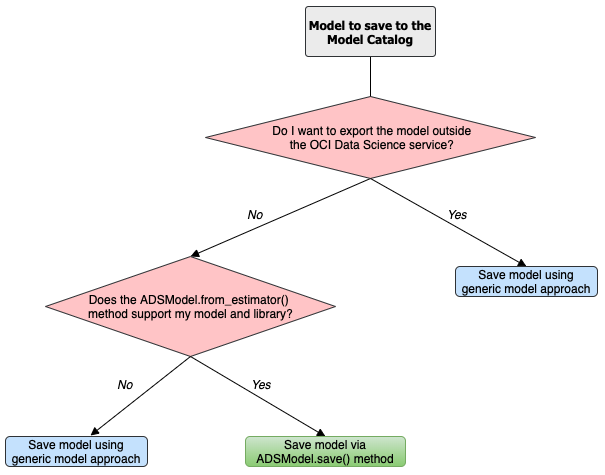

<a id='prepare_adsmodel'></a>
## Preparing an `ADSModel`

The steps to prepare an `ADSModel` include training an `ADSModel` and preparing the model artifacts. Optionally, the model artifacts can be customized and reloaded from disk. Once these steps are complete, the model artifacts are ready to be stored in the model catalog.

<a id='prepare_adsmodel_train'></a>
### Train an `ADSModel`

The dataset `oracle_classification_dataset1` is used to build a Random Forest classifier. The `RandomForestClassifier` class is supported by the `ADSModel` class. The specifics of the dataset features are not important for this notebook demonstration. However, the feature engineering is done automatically using the `auto_transform()` method. The value to predict, that is the target, is `class`. The data is also split into training and test sets. The test set is used later in the notebook to make predictions.

The `RandomForestClassifier` object is converted to into an `ADSModel` using the `from_estimator()` method.

In [ ]:
# Load the dataset
ds_path = path.join("/", "opt", "notebooks", "ads-examples", "oracle_data", "oracle_classification_dataset1_150K.csv")
ds = DatasetFactory.open(ds_path, target="class")

# Data preprocessing
transformed_ds = ds.auto_transform(fix_imbalance=False)
train, test = transformed_ds.train_test_split(test_size=0.15)

# Build the model and convert it to an ADSModel object
rf_clf = RandomForestClassifier(n_estimators=10).fit(train.X.values, train.y.values)
rf_model = ADSModel.from_estimator(rf_clf)

<a id='prepare_adsmodel_ma'></a>
### Prepare the Model Artifact

To prepare the model artifact, the `prepare()` method is used. This method returns a `ModelArtifact` object and also writes a number of model artifact files to the disk. The only required argument to the `prepare()` method is the local path to store the model artifact files.

The output of this cell lists the temporary directory used for the model artifacts and the files that compose the artifact.

In [ ]:
# Prepare the model artifacts
path_to_ADS_model_artifact = tempfile.mkdtemp()
rf_model_artifact = rf_model.prepare(path_to_ADS_model_artifact, force_overwrite=True, 
                                     data_sample=test, data_science_env=True)

# List the template files
print("Model Artifact Path: {}\n\nModel Artifact Files:".format(path_to_ADS_model_artifact))
for file in os.listdir(path_to_ADS_model_artifact):
    if path.isdir(path.join(path_to_ADS_model_artifact, file)):
        for file2 in os.listdir(path.join(path_to_ADS_model_artifact, file)):
            print(path.join(file,file2))
    else:
        print(file)

<a id='prepare_adsmodel_modify'></a>
### Modify the Model Artifact Files

With `ADSModel` approach, the model is saved in ONNX format and called `model.onnx`. There are a number of other files and generally, these do not need to be modified though they can be. 


#### Update `score.py`

The `score.py` file has two methods, `load_model()` and `predict()`. The `load_model()` method deserializes the model and returns it. The `predict()` method accepts data and a model (optional) and returns a dictionary of predicted results. The most common use case for changing the `score.py` file is to add pre and postprocessing steps to the `predict()` method. The model artifact files that are on disk are decoupled from the `ModelArtifact` object that is returned by the `prepare()` method. If changes are made to the model artifact files, the `reload()` method must be run to pick up the changes. See the section on preparing Generic Model artifacts for more details on these files.

Following are the contents of the `score.py` file.

In [ ]:
with open(path.join(path_to_ADS_model_artifact, "score.py"), 'r') as f:
    print(f.read())

#### Update `requirements.txt`

The `prepare()` method automatically encapsulates the notebook's Python libraries their versions in the `requirements.txt` file. This ensures that the model's dependencies can be reproduced. Generally, this file does not need to be modified.

If custom libraries are installed in the notebook then the `requirements.txt` file should be updated. This can be done by calling `pip freeze` and storing the output into the file. The following command captures all of the packages installed in the notebook. It is very likely that only a few of them are required by the model. However, using the following command ensures that all the required packages are present on the system to run the model. We recommend that you update this list to only include what is required if the model is going into a production environment. Generally, a data scientist does not need to modify the `requirements.txt` file.

In [ ]:
%%capture
os.system("pip freeze > '{}'".format(path.join(path_to_ADS_model_artifact, "backup-requirements.txt")))

#### Reloading the Model Artifact

The model artifacts on disk are decoupled from the `ModelArtifact` object. Any changes made on disk must be incorporated back into the `ModelArtifact` object. This is done by using the `reload()` method.

In [ ]:
rf_model_artifact.reload()

With the changes made to the model artifacts and those artifacts being incorporated back into the `ModelArtifact` object, it can be used to make predictions. If there were no changes made to the model artifacts on the disk then the `ModelArtifact` object can be used directly.

The sample problem is a binary classification problem. Therefore, the `predict()` method returns a 1 if the observation is predicted to be in the class that is defined as true. Otherwise, it returns a 0. The following code uses the `predict` method on the `ModelArtifact` object to make predictions on the test data.

In [ ]:
rf_model_artifact.predict(data=test.X, model=rf_model_artifact.load_model())

<a id='prepare_generic'></a>
## Preparing a Generic Model

The steps to prepare a Generic Model are basically the same as those for the `ADSModel` approach. There are a few more details that the data scientist has to take care of. The first step is to train a model. It does not have to be based on the `ADSModel` class. Next, the model has to be serialized and the model artifacts prepared. Preparing the model artifacts include running the `prepare_generic_model()` method, then editing the `score.py` file, and optionally the requirements file. This is then loaded back from the disk with the `reload()` command. Once these steps are complete, the model artifacts are ready to be stored in the model catalog.

<a id='prepare_generic_train'></a>
### Train a Generic Model

The following example uses a Gamma Regressor Model (Generalized Linear Model with a Gamma distribution and a log link function) from sklearn. `ADSModel` does not support this class of model so the Generic Model approach is used.

In [ ]:
from sklearn import linear_model
gamma_reg_model = linear_model.GammaRegressor()
train_X = [[1, 2], [2, 3], [3, 4], [4, 3]]
train_y = [19, 26, 33, 30]
gamma_reg_model.fit(train_X, train_y)

In [ ]:
gamma_reg_model.score(train_X, train_y)

In [ ]:
test_X = [[1, 0], [2, 8]]
gamma_reg_model.predict(test_X)

<a id='prepare_generic_ma'></a>
### Serialize the Model and Prepare the Model Artifact

To prepare the artifact, the model must be serialized. It can be serialized using any desirable method. In this example, the `joblib` serializer is used and it write the file `model.onnx` to a temporary directory. The `prepare_generic_model()` method is used to create the model artifacts in the specified folder. This consists of a set of template files, some of which needs to be customized.

The call to `prepare_generic_model()` returns a `ModelArtifact` object. This is the object that is used to bundle up the model and model artifacts. It is also used to interact with the model catalog.

This cell serializes the model and prepare the model artifacts. The output is a listing of the temporary directory used for the model artifacts and the files that compose the artifact.

In [ ]:
# prepare the model artifact template
path_to_generic_model_artifact = tempfile.mkdtemp()
generic_model_artifact = prepare_generic_model(path_to_generic_model_artifact, fn_artifact_files_included=True, force_overwrite=True, data_science_env=True)

# Serialize the model
import cloudpickle
with open(path.join(path_to_generic_model_artifact, "model.pkl"), "wb") as outfile:
    cloudpickle.dump(gamma_reg_model, outfile)

# List the template files
print("Model Artifact Path: {}\n\nModel Artifact Files:".format(path_to_generic_model_artifact))
for file in os.listdir(path_to_generic_model_artifact):
    if path.isdir(path.join(path_to_generic_model_artifact, file)):
        for file2 in os.listdir(path.join(path_to_generic_model_artifact, file)):
            print(path.join(file,file2))
    else:
        print(file)

<a id='prepare_generic_modify'></a>
### Modify the Model Artifact Files

The Generic Model approach provides a template that needs to be customized to the specific use case. Specifically, the `score.py` and `requirements.txt` files need to be updated.

#### Update `score.py`

Since the Generic Model approach is agnostic to the model and the serialization method being used, the data scientist must provide information about this. The `score.py` file provides two methods that need to be updated. These are the `load_model()` and `predict()` methods.

The `load_model()` method takes no parameters and returns the deserialized model object. The template code gives an example of how to do this for the most common serialization method. However, the deserialization method that is used must complement the serialization method used.

The `score.py` file also contains a templated method called `predict()`. This method takes any arbitrary data object and an optional model and returns a dictionary of predictions. The role of this method is to make predictions based on new data. The method can be written to perform any pre-prediction and post-prediction operations that are needed. These would be tasks such as feature engineering the raw input data and logging predictions results.

The next cell prints out the contents of the `score.py` file.

In [ ]:
with open(path.join(path_to_generic_model_artifact, "score.py"), 'r') as f:
    print(f.read())

The next cell updates the `score.py` file to support the gamma regression model. The `load_model()` method has been updated to use the `joblib.load()` function to read in the model and deserialize it. The `predict()` method has been modified so that it makes calls to `_handle_input()` and `_handle_output()` methods. This allows the `predict` method to do arbitrary operations before and after the prediction.

In [ ]:
%%capture
score = '''
import json
import os
from cloudpickle import cloudpickle


model_name = 'model.pkl'

def load_model(model_file_name=model_name):
    """
    Loads model from the serialized format

    Returns
    -------
    model:  a model instance on which predict API can be invoked
    """
    model_dir = os.path.dirname(os.path.realpath(__file__))
    contents = os.listdir(model_dir)
    if model_file_name in contents:
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), model_file_name), "rb") as file:
            return cloudpickle.load(file)
    else:
        raise Exception('{0} is not found in model directory {1}'.format(model_file_name, model_dir))


def predict(data, model=load_model()):
    """
    Returns prediction given the model and data to predict

    Parameters
    ----------
    model: Model instance returned by load_model API
    data: Data format as expected by the predict API of the core estimator. For eg. in case of sckit models it could be numpy array/List of list/Panda DataFrame

    Returns
    -------
    predictions: Output from scoring server
        Format: {'prediction':output from model.predict method}

    """
    
    # from pandas import read_json, DataFrame
    # from io import StringIO
    # X = read_json(StringIO(data)) if isinstance(data, str) else DataFrame.from_dict(data)
    return {'prediction':model.predict(data).tolist()}
'''

with open(path.join(path_to_generic_model_artifact, "score.py"), 'w') as f:
    print(f.write(score))

#### Update `requirements.txt`

The templated `requirements.txt` file contains only the most basic libraries. This file has to be customized to capture the packages that were used to build the model. If the model artifact is going to be deployed to Oracle Functions, then the `fdk` package needs to be included.

The following cell outputs the current contents.

In [ ]:
with open(path.join(path_to_generic_model_artifact, "requirements.txt"), 'r') as f:
    print(f.read())

Generally, the `requirements.txt` file will need to be updated. Initially it only stores packages that functions requires. The user will need to add the libraries necessary to run their model and pre-processing. It is advised to update this list to only include what is required if the model is going into a production environment.

#### Reloading the Model Artifact

The model artifacts on disk are decoupled from the `ModelArtifact` object. Any changes made on disk must be incorporated back into the `ModelArtifact` object. This is done by using the `reload()` method.

In [ ]:
generic_model_artifact.reload(model_file_name='model.pkl')

With the changes made to the model artifacts and those artifacts being incorporated back into the `ModelArtifact` object, it can be used to make predictions. When the `predict()` method is used, there is no need for the preprocessing to be done before calling `predict()`. This is because the preprocessing steps have been coded into the `score.py` file. The advantage of this is that the preprocessing is coupled with the model and not the code that is calling the `predict()` method so the code is more maintainable. 


In [ ]:
data =  [[3, 4], [4, 5]]
generic_model_artifact.model.predict(data).tolist()

<a id='save'></a>
# 3. Save the Model Artifact to the Model Catalog

The `ModelArtifact` object is used to store the model artifacts into the model catalog. Saving the model artifact requires the 
[OCID](https://docs.cloud.oracle.com/iaas/Content/General/Concepts/identifiers.htm) for the compartment and project that it is to be stored under. The model artifacts can be stored in any project that the user has access too. However, the most common use case is to store the model artifacts to the same compartment and project that the notebook session belongs too. There are environmental variables in the notebook session that contains this information. The environment variables `NB_SESSION_COMPARTMENT_OCID` and `PROJECT_OCID` contain the compartment and project OCIDs, respectively, that are associated with the notebook session.

Metadata can also be stored with the model artifacts. If the notebook is under Git version control the `save()` method automatically captures that the relevant information so that there is a link between the code used to create the model and the model artifacts. The `save()` method does not save the notebook and commit any changes. This should be done by the data scientist before storing the model in the model catalog. The `ignore_pending_changes` parameter is used to control this. The model catalog also accepts a description, display name, a path to the notebook used to train the model, tags, and more.

The `save()` method returns a `Model` object that is a connection to the model catalog for the model that was just saved. It contains information about the model catalog entry such as the OCID, the metadata provided to the catalog, the user that stored the model, and so on.

The optional parameter `auth` can be used to specify the preferred authentication method.

In [ ]:
# Saving the model artifact to the model catalog: 
mc_model = rf_model_artifact.save(project_id=os.environ['PROJECT_OCID'], compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'], 
                                  display_name="RF Classifier", description="A sample Random Forest classifier", 
                                  ignore_pending_changes=True, auth=ads.common.auth.api_keys())
mc_model

Information about the model can also be found in the console. It can be found on the Projects page under the Models section. It should look similar to:
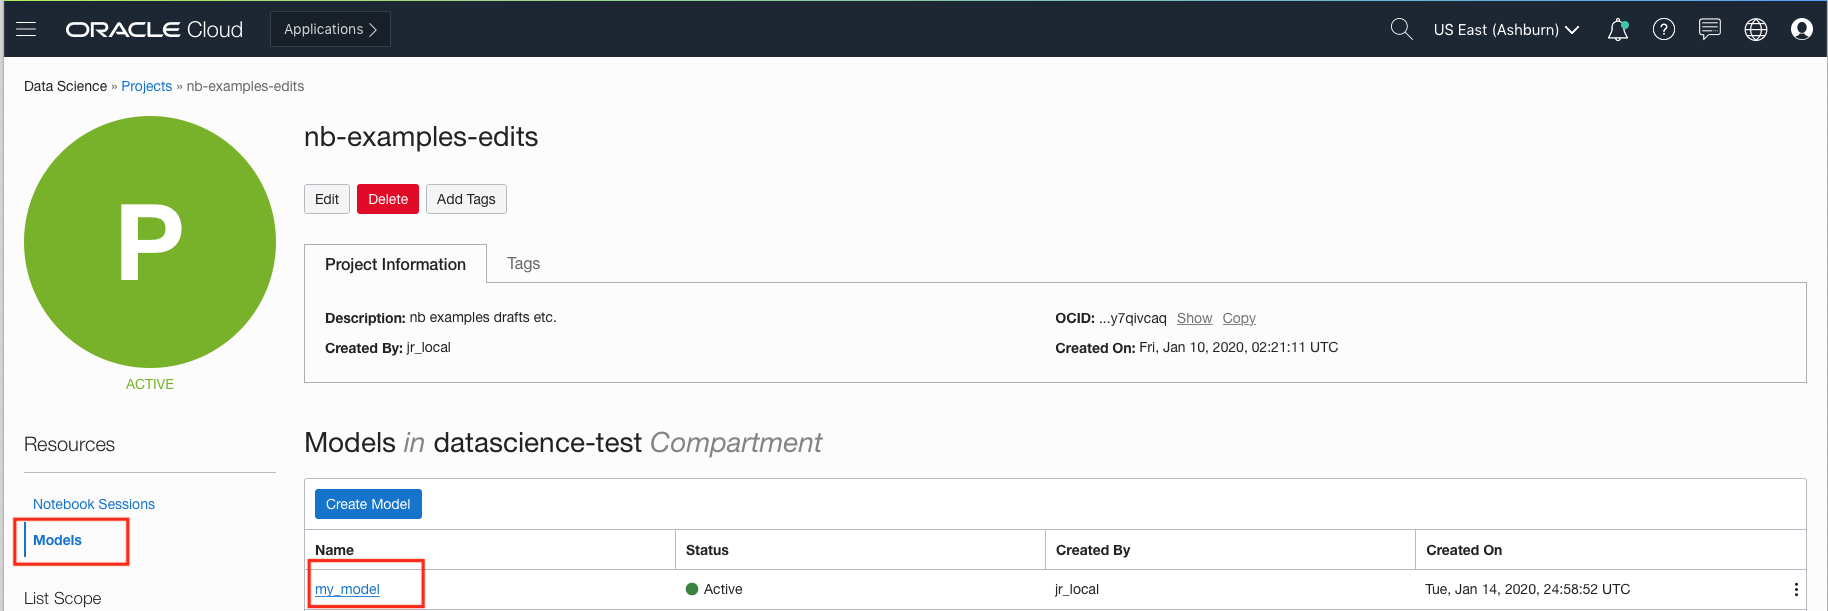

<a id='list'></a>
# 4. List Models in the Model Catalog

The `ModelCatalog` object is used to interact with the model catalog. This class allows access to all models in a compartment. Using this class, entries in the model catalog can be listed, deleted, and downloaded. It also provides access to specific models so that the metadata can be updated and the model can be activated and deactivated.

When model artifacts are saved to the model catalog, they are associated with a compartment and a project. The `ModelCatalog` provides access across projects and all model catalog entries in a compartment are accessible. When creating a `ModelCatalog` object, the compartment OCID must be provided. For most use cases, the data scientist will want to access the model catalog associated with the compartment that the notebook is in. The environment variable `NB_SESSION_COMPARTMENT_OCID` provides the compartment OCID associated with the current notebook. The `compartment_id` parameter is optional. When it is not specified, the compartment for the current notebook will be used.

The method `list_models()` returns a list of entries in the model catalog as a `ModelSummaryList` object. By default, it only returns the entries that are active. The parameter `include_deleted=True` can override this behaviour and return all entries.

In [ ]:
# Create a connection to the current compartment's model catalog
mc = ModelCatalog(compartment_id=os.environ['NB_SESSION_COMPARTMENT_OCID'])

# Get a list of the entries in the model catalog
mc_list = mc.list_models(include_deleted=True)
mc_list

The `filter()` method accepts a boolean vector and returns a `ModelSummaryList` object that has only the selected entries. This can be combined with a lambda function to provide an arbitrary selection of models based on the properties of the `ModelSummaryList`. The following example uses this approach to select only entries that are in the current notebook's project.

In [ ]:
mc_list.filter(lambda x: x.project_id == os.environ['PROJECT_OCID'])

The `ModelSummaryList` object can be treated as a list of `Model` objects. An individual compartment can be accessed by providing an index value. In addition, the components of the `Model` object can be accessed as attributes of the object. In the following example, the code iterates over the list of models and print the model name if the model is in an active state. If the model is not active, an error occurs.

In [ ]:
for i in range(len(mc_list)):
    try:
        print(mc_list[i].display_name)
    except ValueError:
        pass

A Pandas dataframe representation of a `ModelSummaryList` object can be accessed with the `df` attribute. Using the dataframe representation standard Pandas operations can be used. In the following example, entries are sorted, in ascending order, by the creation time.

In [ ]:
df = mc_list.df
df.sort_values('time_created', axis=0)

<a id='download'></a>
# 5. Download a Model Artifact

The `download_model()` of the `ModelCatalog` is used to retrieve a model artifact from the model catalog. This process can be used to change the model artifacts or make the model accessible for predictions. While some of the model artifact metadata is mutable, the model and scripts are immutable. If changes are made, the model artifacts must be saved back to the model catalog as a new entry.

The `download_model()` requires a model OCID value and a target directory for the artifact files. This method returns a `ModelArtifact` object. It can be used to make predictions by calling the `predict()` method. If the model artifact is updated, the `reload()` method must be called to synchronize the changes on the disk with the `ModelArtifact` object. The model artifact can then be saved as a new entry into the model catalog with the `save()` method.

In this example, the model that was stored in the model catalog will be downloaded. The resulting `ModelArtifact` object is then used to make predictions.

In [ ]:
# Download the model that was saved to the model catalog, if it exists
if mc.list_models().filter(lambda x: x.id == mc_model.id) is not None:
    download_path = tempfile.mkdtemp()
    dl_model_artifact = mc.download_model(mc_model.id, tempfile.mkdtemp(), force_overwrite=True)
    print(dl_model_artifact.predict(data=test.X, model=dl_model_artifact.load_model()))

<a id='retrieve'></a>
# 6. Retrieve a Model from the Model Catalog

The `get_model()` method of the `ModelCatalog` class allows for an entry in the model catalog to be retrieved. The returned object is a `Model` object. The difference between `get_model()` and `download_model()` is that the `download_model()` returns a `ModelArtifact` object and the `get_model()` returns the `Model` object. The `Model` object allows for interaction with the entry in the model catalog where the `ModelArtifact` allows interaction with the model and its artifacts.

In this example, the model that was stored in the model catalog is retrieved. The `get_model()` method requires the OCID of the entry in the model catalog.

In [ ]:
if mc.list_models().filter(lambda x: x.id == mc_model.id) is not None:
    retrieved_model = mc.get_model(mc_model.id)
    retrieved_model.show_in_notebook()

Models can also be retrieved from the model catalog by indexing the results from the `list_models()` method. In the following example, the code iterates through all of the entries in the model catalog and look for the entry that has an OCID that matches the model that was previously stored in the model catalog the this notebook. If it finds it, the model catalog information is displayed.

In [ ]:
is_found = False
for i in range(len(mc_list)):
    try:
        if mc_list[i].id == mc_model.id:
            mc_list[i].show_in_notebook()
            is_found = True
    except ValueError:
        pass
if not is_found:
    print("The model was not found. Could it be disabled?")

<a id='metadata'></a>
# 7. Working with Metadata

Metadata is stored with the model artifacts and this data can be accessed through the `Model` object.  

This is a list of metadata attributes:

* `id`: Model OCID
* `compartment_id`: Compartment OCID. It is possible to move a model catalog entry to a new compartment.
* `project_id`: Project OCID. Each model catalog entry belongs to a compartment and project.
* `display_name`: Name to be displayed on the Models page. Names do not have to be unique.
* `description`: A detailed description of the model artifact.
* `lifecycle_state`: The state of the model. It can be `ACTIVE` or `INACTIVE`.
* `time_created`: The date and time that the model artifacts were stored in the model catalog.
* `created_by`: The OCID of the account that created the model artifact.
* `freeform_tags`: User applied tags.
* `defined_tags`: Tags created by the infrastructure.
* `user_name`: User name of the account that created the entry.
* `provenance_metadata`: Information about the:
    * `git_branch`: git branch
    * `git_commit`: git commit hash
    * `repository_url`: URL of the git repository. 
    * `script_dir`: The directory of the training script. 
    * `training_script`: The filename of the training script.
    
The `provenance_metadata` attribute returns a [ModelProvenance](https://oracle-cloud-infrastructure-python-sdk.readthedocs.io/en/latest/api/data_science/models/oci.data_science.models.ModelProvenance.html#oci.data_science.models.ModelProvenance) object. This object has the attributes to access the metadata.

<a id='metadata_access'></a>
## Access Metadata

The `show_in_notebook()` method prints a table of the metadata. Individual metadatum can be accessed as an attribute of the `Model` object. For example, the model description can be accessed with the `description` attribute. 

The next cell accesses and print several attributes and also display the `show_in_notebook()` output.

In [ ]:
# Print the defined tags in a nice format
print("defined tags attribute")
def print_dict(dictionary, level=0):
    for key in dictionary:
        value = dictionary[key]
        print('\t'*level, end='')
        if isinstance(value, dict):
            print("Key: {}".format(key))
            print_dict(value, level+1)
        else:
            print("Key: {}, Value: {}".format(key, value))
print_dict(mc_model.defined_tags)

# Print the user_name
print("\nUser name: {}".format(mc_model.user_name))

# Print the provenance_metadata
print("\nTraining script: {}".format(mc_model.provenance_metadata.training_script))

# Show in notebook
mc_model.show_in_notebook()

<a id='metadata_update'></a>
## Update Metadata

Model artifacts are immutable but the metadata is mutable. Metadata attributes can be updated in the `Model` object. However, those changes are not be made to the model catalog until the `commit()` method is called.

In the next cell, the model's display name and description are updated. These changes are committed, and then the model is retrieved from the model catalog. The metadata is displayed to demonstrate that it was changed.

In [ ]:
# Update some metadata
mc_model.display_name = "Update Display Name"
mc_model.description = "This description has been updated"
mc_model.freeform_tags = {'isUpdated': 'True'}
mc_model.commit()

# Retrieve the updated model from the model catalog
if mc.list_models().filter(lambda x: x.id == mc_model.id) is not None:
    retrieved_model = mc.get_model(mc_model.id)
    retrieved_model.show_in_notebook()

<a id='activate_deactivate'></a>
# 8. Activating and Deactivating a Model Catalog Entry

Entries in the model catalog can be set as active or inactive. An inactive model is similar to archiving it. The model artifacts are not deleted, but deactivated entries are not returned in default queries. The `deactivate()` method of a `Model` object sets a flag in the `Model` object that it is inactive. However, the `commit()` method must be called to update the model catalog to deactivate the entry.

The opposite of the `deactivate()` is the `activate()` method. It flags a `Model` object as active and the `commit()` method must be called to update the model catalog.

In the following example, the model that was stored in the model catalog in this notebook is set as inactive. The `lifecycle_state` shows it as `INACTIVE`.

In [ ]:
mc_model.deactivate()
mc_model.commit()
if mc.list_models().filter(lambda x: x.id == mc_model.id) is not None:
    retrieved_model = mc.get_model(mc_model.id)
    retrieved_model.show_in_notebook()

The model can be activated by calling the `activate()` method followed by `commit()`. In this output, the `lifecycle_state` is now `ACTIVE`:

In [ ]:
mc_model.activate()
mc_model.commit()
if mc.list_models().filter(lambda x: x.id == mc_model.id) is not None:
    retrieved_model = mc.get_model(mc_model.id)
    retrieved_model.show_in_notebook()

<a id='delete'></a>
# 9. Deleting a Model Catalog Entry

The `delete_model()` method of the `ModelCatalog` class is used to delete entries from the model catalog. It takes the model artifact's OCID as a parameter. Once a model catalog entry has been deleted it cannot be restored. It is possible to download the model artifact to store in a backup.

The `delete_model()` method returns `True` if the model was deleted. Repeated calls to `delete_model()` also returns true. If the supplied OCID is invalid or the system fails to delete the model catalog entry, it returns `False`.

The difference between `deactive()` and `delete()` is that `deactivate()` does not remove the model artifacts, it simply marks them as inactive and is not be listed when the `list_models()` method is called by default. The `delete()` method permanently deletes the model artifact.

In the next cell, the model that was stored in the model catalog as part of this notebook is deleted.

In [ ]:
mc.delete_model(mc_model.id)